In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, json, random, cv2, numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50

import albumentations as A
from albumentations.pytorch import ToTensorV2

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/RMDS_Segmentation_Assignment.zip"

In [ ]:
BASE_DIR = "/content/RM_Segmentation_Assignment_ds"
folders = {
    "train_imgs": os.path.join(BASE_DIR, "train-300/data"),
    "train_json": os.path.join(BASE_DIR, "train-300/labels.json"),
    "val_imgs": os.path.join(BASE_DIR, "validation-300/data"),
    "val_json": os.path.join(BASE_DIR, "validation-300/labels.json"),
    "test_imgs": os.path.join(BASE_DIR, "test-30")
}

print("Train images:", len(os.listdir(folders['train_imgs'])))
print("Val images:", len(os.listdir(folders['val_imgs'])))
print("Test images:", len(os.listdir(folders['test_imgs'])))

Train images: 300
Val images: 300
Test images: 30


In [ ]:
with open(folders['train_json']) as fh:
    ann_json = json.load(fh)
print("Annotation keys:", list(ann_json.keys()))

Annotation keys: ['info', 'licenses', 'categories', 'images', 'annotations']


#Exploratory Data Analysis

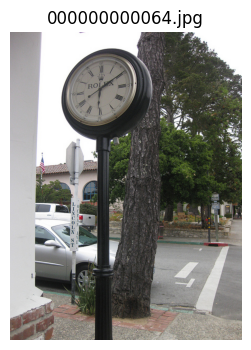

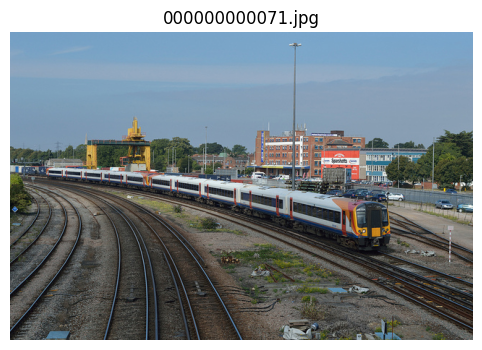

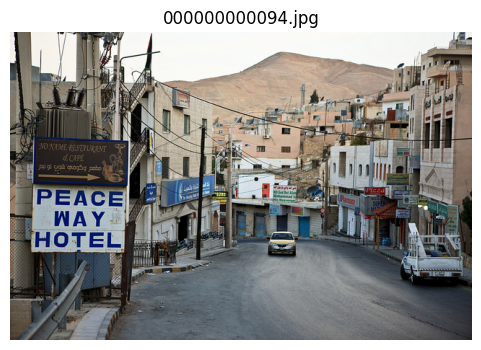

In [ ]:
sample_paths = sorted(glob(os.path.join(folders['train_imgs'], "*.jpg")))[:3]
for p in sample_paths:
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4)); plt.imshow(img); plt.title(os.path.basename(p)); plt.axis('off'); plt.show()

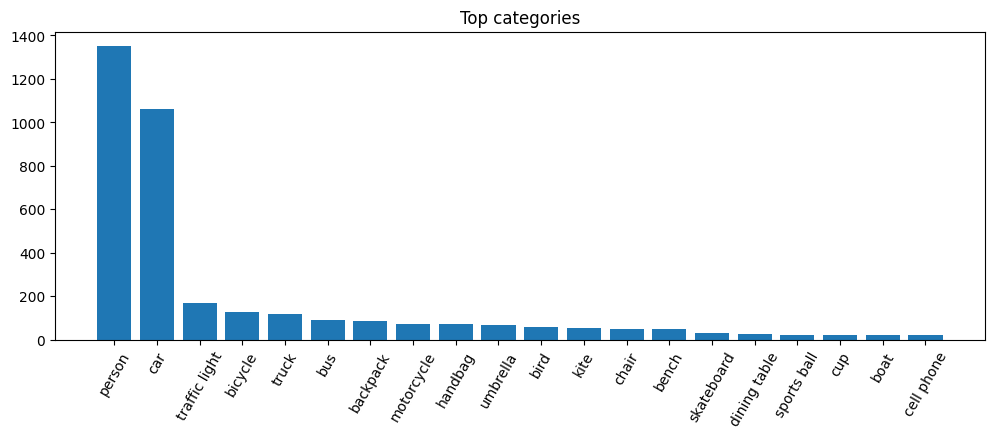

In [ ]:
cat_map = {c['id']: c['name'] for c in ann_json['categories']}
freq = defaultdict(int)
for a in ann_json['annotations']:
    freq[a['category_id']] += 1
pairs = sorted(freq.items(), key=lambda x: x[1], reverse=True)
labels = [cat_map[k] for k,_ in pairs[:20]]
vals   = [v for _,v in pairs[:20]]
plt.figure(figsize=(12,4)); plt.bar(labels, vals); plt.xticks(rotation=60); plt.title("Top categories"); plt.show()

In [ ]:
TARGET_NAMES = ['person', 'cat', 'sports ball', 'book']
TARGET_MAP = {name: idx+1 for idx, name in enumerate(TARGET_NAMES)}
INV_TARGET_MAP = {v:k for k,v in TARGET_MAP.items()}

NUM_OUTPUT_CLASSES = len(TARGET_NAMES) + 1

print("Target mapping:", TARGET_MAP)

Target mapping: {'person': 1, 'cat': 2, 'sports ball': 3, 'book': 4}


In [ ]:
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

class SegCOCODataset(Dataset):
    def __init__(self, images_dir, ann_path, transform=None, desired_map=TARGET_MAP):
        self.img_dir = images_dir
        self.coco = COCO(ann_path)
        self.ids = self.coco.getImgIds()
        self.transform = transform
        self.cocoid_to_cls = {}
        for tname, cls_idx in desired_map.items():
            coco_ids = self.coco.getCatIds(catNms=[tname])
            for cid in coco_ids:
                self.cocoid_to_cls[cid] = cls_idx

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = np.array(Image.open(img_path).convert("RGB"))

        H, W = img_info['height'], img_info['width']
        mask = np.zeros((H, W), dtype=np.uint8)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        for a in anns:
            cid = a['category_id']
            if cid not in self.cocoid_to_cls:
                continue
            cls_idx = self.cocoid_to_cls[cid]
            seg = a.get('segmentation', None)
            if seg is None:
                continue
            try:
                if isinstance(seg, list):
                    rles = mask_utils.frPyObjects(seg, H, W)
                    rle = mask_utils.merge(rles)
                elif isinstance(seg, dict) and 'counts' in seg:
                    rle = seg
                else:
                    continue
                m = mask_utils.decode(rle)
                if m.ndim == 3:
                    m = m.max(axis=2)
                mask[m == 1] = cls_idx
            except Exception as e:
                continue


        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask).long()
        elif torch.is_tensor(mask):
            if mask.ndim == 3 and mask.shape[0] == 1:
                mask = mask.squeeze(0)
            mask = mask.long()
        else:
            mask = torch.tensor(np.array(mask)).long()

        return image, mask

In [ ]:
train_aug = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
val_aug = A.Compose([
    A.Resize(256,256),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

train_dataset = SegCOCODataset(folders['train_imgs'], folders['train_json'], transform=train_aug)
val_dataset   = SegCOCODataset(folders['val_imgs'], folders['val_json'], transform=val_aug)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_deeplab(num_classes_out):
    model = deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, num_classes_out, kernel_size=1)
    return model

SEG_MODEL = make_deeplab(NUM_OUTPUT_CLASSES).to(device)
LOSS_FN = nn.CrossEntropyLoss()
OPT = torch.optim.Adam(SEG_MODEL.parameters(), lr=1e-4, weight_decay=1e-5)
SCHED = torch.optim.lr_scheduler.StepLR(OPT, step_size=5, gamma=0.5)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:01<00:00, 103MB/s]


In [ ]:
EPOCHS = 10
best_val = float('inf')
for ep in range(EPOCHS):
    SEG_MODEL.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        out = SEG_MODEL(imgs)['out']
        loss = LOSS_FN(out, masks)

        OPT.zero_grad()
        loss.backward()
        OPT.step()

        running_loss += loss.item() * imgs.size(0)

    SCHED.step()
    train_epoch_loss = running_loss / len(train_loader.dataset)


    SEG_MODEL.eval()
    val_loss = 0.0
    correct = 0
    total_pixels = 0
    with torch.no_grad():
        for vimgs, vmasks in val_loader:
            vimgs = vimgs.to(device)
            vmasks = vmasks.to(device)
            vout = SEG_MODEL(vimgs)['out']
            l = LOSS_FN(vout, vmasks)
            val_loss += l.item() * vimgs.size(0)

            preds = torch.argmax(vout, dim=1)
            correct += torch.sum(preds == vmasks).item()
            total_pixels += vmasks.numel()

    val_epoch_loss = val_loss / len(val_loader.dataset)
    pixel_acc = correct / total_pixels * 100

    print(f"Epoch {ep+1}/{EPOCHS} | Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f} | Pixel Acc: {pixel_acc:.2f}%")

    if val_epoch_loss < best_val:
        best_val = val_epoch_loss
        torch.save(SEG_MODEL.state_dict(), "/content/best_deeplab_assignment.pth")
        print("Saved best model.")

Epoch 1/10 | Train Loss: 1.0782 | Val Loss: 0.6236 | Pixel Acc: 95.45%
Saved best model.
Epoch 2/10 | Train Loss: 0.5698 | Val Loss: 0.4012 | Pixel Acc: 95.19%
Saved best model.
Epoch 3/10 | Train Loss: 0.3657 | Val Loss: 0.3066 | Pixel Acc: 95.51%
Saved best model.
Epoch 4/10 | Train Loss: 0.2655 | Val Loss: 0.2162 | Pixel Acc: 95.90%
Saved best model.
Epoch 5/10 | Train Loss: 0.2143 | Val Loss: 0.1792 | Pixel Acc: 95.82%
Saved best model.
Epoch 6/10 | Train Loss: 0.1793 | Val Loss: 0.1646 | Pixel Acc: 96.14%
Saved best model.
Epoch 7/10 | Train Loss: 0.1589 | Val Loss: 0.1620 | Pixel Acc: 96.19%
Saved best model.
Epoch 8/10 | Train Loss: 0.1411 | Val Loss: 0.1479 | Pixel Acc: 96.42%
Saved best model.
Epoch 9/10 | Train Loss: 0.1280 | Val Loss: 0.1416 | Pixel Acc: 96.27%
Saved best model.
Epoch 10/10 | Train Loss: 0.1210 | Val Loss: 0.1572 | Pixel Acc: 95.85%


In [ ]:
COLOR_PALETTE = {
    0: (0,0,0),
    1: (255,0,0),         # person - red
    2: (0,255,0),         # cat - green
    3: (0,0,255),         # sports ball - blue
    4: (255,255,0)        # book - yellow
}

def mask_to_color(mask_arr):
    h,w = mask_arr.shape
    out = np.zeros((h,w,3), dtype=np.uint8)
    for cls_idx, col in COLOR_PALETTE.items():
        out[mask_arr==cls_idx] = col
    return out

In [ ]:
def run_and_show_sample(img_path, model):
    model.eval()
    orig = np.array(Image.open(img_path).convert("RGB"))
    h,w = orig.shape[:2]

    aug = A.Compose([A.Resize(256,256), A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)), ToTensorV2()])
    t = aug(image=orig)
    tensor = t['image'].unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(tensor)['out']
        pred = torch.argmax(out.squeeze(0), dim=0).cpu().numpy().astype(np.uint8)

    pred_up = cv2.resize(pred, (w,h), interpolation=cv2.INTER_NEAREST)
    col_mask = mask_to_color(pred_up)
    overlay = cv2.addWeighted(orig, 0.6, col_mask, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(orig); plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(col_mask); plt.title("Predicted mask (colors)"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis('off')
    plt.tight_layout(); plt.show()

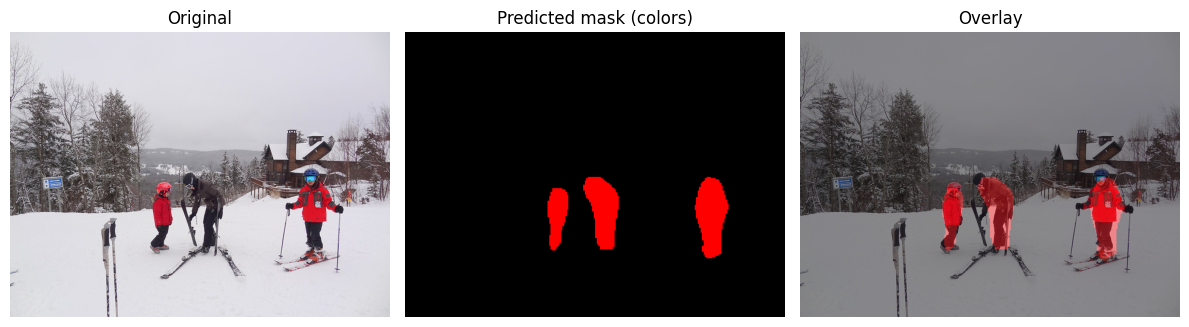

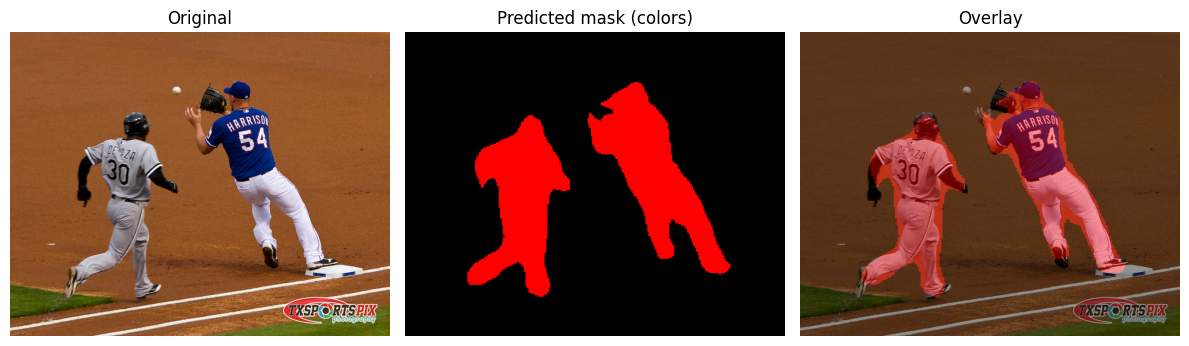

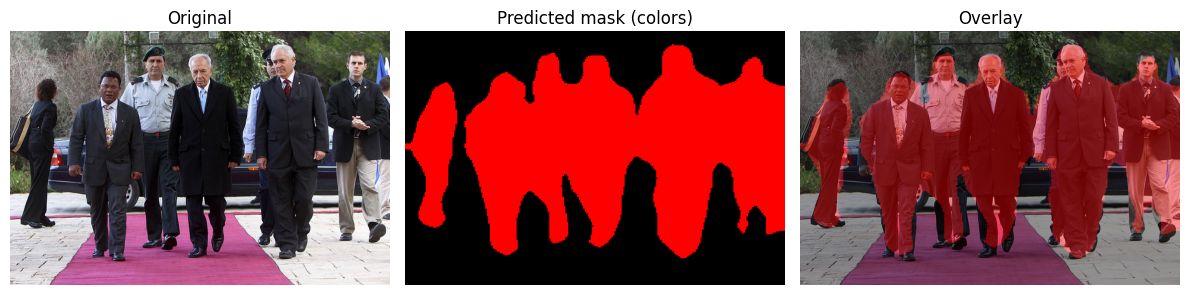

In [ ]:
SEG_MODEL.load_state_dict(torch.load("/content/best_deeplab_assignment.pth", map_location=device))

test_files = sorted(glob(os.path.join(folders['test_imgs'], "*.jpg")))
sample_tests = random.sample(test_files, k=3) if len(test_files)>=3 else test_files
for f in sample_tests:
    run_and_show_sample(f, SEG_MODEL)